In [1]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity,euclidean_distances
import pickle
import pandas as pd

In [2]:


def load_embeddings(pickle_file_path):
    with open(pickle_file_path, 'rb') as pickle_file:
        loaded_data_dict = pickle.load(pickle_file)

    # Convert lists to numpy arrays
    data = loaded_data_dict["embedding"]
    labels = np.array(loaded_data_dict["target"])
    return data, labels, loaded_data_dict

In [62]:


# Dados fictícios

def run_queries(query_embedding, data_embeddings, similarity_function):
    similarity_scores = similarity_function(query_embedding.reshape(1, -1), data_embeddings).flatten()
    sorted_indices = np.argsort(similarity_scores)
    return sorted_indices, similarity_scores


def map_relevant_labels(array1, array2):
    """
    Compara dois arrays e retorna um novo array de 0s e 1s, indicando se os elementos correspondentes são iguais.

    Parameters:
    - array1: Primeiro array a ser comparado (NumPy array).
    - array2: Segundo array a ser comparado (NumPy array).

    Returns:
    - Novo array contendo 0s e 1s.
    """
    if array1.shape != array2.shape:
        raise ValueError("Os arrays devem ter o mesmo tamanho")

    result = np.where(array1 == array2, 1, 0)
    return result

def calculate_ap_at_k(relevant_labels, k_value):
    ap_num = 0
    for k in range(k_value):
        precision_at_k = sum(relevant_labels[:k+1]) / (k+1)
        # calculate numerator value for ap
        ap_num += precision_at_k * relevant_labels[k]
        # print(f"P@{k+1}_{i+1} = {round(precision_at_k,2)}")

    ap_q = ap_num / k_value

    return ap_q

def calculate_ar_at_k(sorted_labels, true_labels, k_value):
    ar_num = 0
    target_label = true_labels[0]
    relevant_labels = np.where(sorted_labels == true_labels, 1, 0)
    for k in range(k_value):
        tp = np.sum((sorted_labels[:k+1] == target_label) & (true_labels[:k+1] == target_label))
        fn = np.sum((sorted_labels[:k+1] != target_label) & (true_labels[:k+1] == target_label))
        recall_at_k = tp / (tp + fn) if (tp + fn) > 0 else 0
        
        ar_num += recall_at_k * relevant_labels[k]

    ar_q = ar_num / k_value    
    return ar_q

def calculate_f1_at_k(sorted_labels, true_labels, k_value):
    f1_num = 0
    target_label = true_labels[0]
    relevant_labels = np.where(sorted_labels == true_labels, 1, 0)
    for k in range(k_value):
        tp = np.sum((sorted_labels[:k+1] == target_label) & (true_labels[:k+1] == target_label))
        fn = np.sum((sorted_labels[:k+1] != target_label) & (true_labels[:k+1] == target_label))
        fp = np.sum((sorted_labels[:k+1] == target_label) & (true_labels[:k+1] != target_label))

        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1_score_at_k = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        f1_num += f1_score_at_k * relevant_labels[k]

    af1_q = f1_num / k_value    
    return af1_q

def evaluate_retrieval_pipeline(
        data_embeddings,
        data_labels, 
        query_embeddings, 
        query_labels, 
        k,
        similarity_function
        ):
    
    ap_at_k_list = []
    ar_at_k_list = []
    af1_at_k_list = []
    for q in range(len(query_embeddings)):
        query_label = query_labels[q] 
        sorted_indices, _ = run_queries(query_embeddings[q], data_embeddings, similarity_function)
        sorted_labels = data_labels[sorted_indices]
        # [1,0,1,1,1,0] relevant label = 1
        true_labels = np.full(len(sorted_labels), query_label)
        relevant_labels = map_relevant_labels(sorted_labels, true_labels)
        average_precision = calculate_ap_at_k(relevant_labels, k)
        average_recall = calculate_ar_at_k(sorted_labels, true_labels, k)
        average_f1score = calculate_f1_at_k(sorted_labels, true_labels, k)
        ap_at_k_list.append(average_precision)
        ar_at_k_list.append(average_recall)
        af1_at_k_list.append(average_f1score)


    map_at_k = sum(ap_at_k_list) / len(query_embeddings)
    mar_at_k = sum(ar_at_k_list) / len(query_embeddings)
    maf1_at_k = sum(af1_at_k_list) / len(query_embeddings)
    
    print(f"mAP@{k} = {round(map_at_k, 2)}")
    print(f"mAR@{k} = {round(mar_at_k, 2)}")
    print(f"mAF1@{k} = {round(maf1_at_k, 2)}")

    return round(map_at_k, 2), round(mar_at_k, 2), round(maf1_at_k, 2)

def dot_product(query_embedding, data_embeddings):
    distances = np.dot(data_embeddings, query_embedding.reshape(-1, 1))
    # smilarity = 1 / (1 + distances)
    return distances

def euclidian(query_embedding, data_embeddings):
    distances = euclidean_distances(query_embedding, data_embeddings).flatten()
    # smilarity = 1 / (1 + distances)
    return distances

def cosine_similarity_func(query_embedding, data_embeddings):
    smilarity = cosine_similarity(query_embedding, data_embeddings).flatten()
    distances = 1 - smilarity
    return distances


def normalize_with_L2_norm(vector):
    """
    Function to normalize a vector using the L2 (Euclidean) norm.

    Parameters:
        vector (numpy.ndarray): The vector to be normalized.

    Returns:
        numpy.ndarray: The normalized vector.
    """
    norm = np.linalg.norm(vector)
    normalized_vector = vector / norm
    return normalized_vector

# Example of using the function
vector = np.array([3, 4])
normalize_with_L2_norm(vector)

array([0.6, 0.8])

In [63]:
semant_labels_test

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3], dtype=int64)

In [7]:
path_test = './efficientnetb0_4096_autoencoder_test.pickle'
path_train = './efficientnetb0_4096_autoencoder_train.pickle'
encod_data_test, encod_labels_test, _ = load_embeddings(path_test)
encod_data_train, encod_labels_train, _ = load_embeddings(path_train)

path_test = './efficientnetb0_4096_pretrained_test.pickle'
path_train = './efficientnetb0_4096_pretrained_train.pickle'
triplet_data_test, triplet_labels_test, _ = load_embeddings(path_test)
triplet_data_train, triplet_labels_train, _ = load_embeddings(path_train)

path_test = 'efficientnet_SwaV_test.pickle'
path_train = './efficientnet_SwaV_train.pickle'
swav_data_test, swav_labels_test, _ = load_embeddings(path_test)
swav_data_train, swav_labels_train, _ = load_embeddings(path_train)

path_test = '../semantic/semantic_test.pickle'
path_train = '../semantic/semantic_train.pickle'
semant_data_test, semant_labels_test, _ = load_embeddings(path_test)
semant_data_train, semant_labels_train, _ = load_embeddings(path_train)

#############################################################

path_test = '../semantic/semantic_att_efficientnetb0_encoder_test.pickle'
path_train = '../semantic/semantic_att_efficientnetb0_encoder_train.pickle'
semant_encod_data_test, semant_encod_labels_test, _ = load_embeddings(path_test)
semant_encod_data_train, semant_encod_labels_train, _ = load_embeddings(path_train)

path_test = '../semantic/semantic_att_efficientnetb0_test.pickle'
path_train = '../semantic/semantic_att_efficientnetb0_train.pickle'
semant_triplet_data_test, semant_triplet_labels_test, _ = load_embeddings(path_test)
semant_triplet_data_train, semant_triplet_labels_train, _ = load_embeddings(path_train)

path_test = '../semantic/semantic_att_efficientnet_SwaV_test.pickle'
path_train = '../semantic/semantic_att_efficientnet_SwaV_train.pickle'
semant_swav_data_test, semant_swav_labels_test, _ = load_embeddings(path_test)
semant_swav_data_train, semant_swav_labels_train, _ = load_embeddings(path_train)

In [19]:
encod_data_train = normalize_with_L2_norm(encod_data_train)
encod_data_test = normalize_with_L2_norm(encod_data_test)

triplet_data_train = normalize_with_L2_norm(triplet_data_train)
triplet_data_test = normalize_with_L2_norm(triplet_data_test)

swav_data_train = normalize_with_L2_norm(swav_data_train)
swav_data_test = normalize_with_L2_norm(swav_data_test)

semant_data_train = normalize_with_L2_norm(semant_data_train)
semant_data_test = normalize_with_L2_norm(semant_data_test)


semant_encod_data_train = normalize_with_L2_norm(semant_encod_data_train)
semant_encod_data_test = normalize_with_L2_norm(semant_encod_data_test)

semant_triplet_data_train = normalize_with_L2_norm(semant_triplet_data_train)
semant_triplet_data_test = normalize_with_L2_norm(semant_triplet_data_test)

semant_swav_data_train = normalize_with_L2_norm(semant_swav_data_train)
semant_swav_data_test = normalize_with_L2_norm(semant_swav_data_test)


In [21]:
emb_bundle = [
    ('autoenconder', encod_data_train, encod_labels_train, encod_data_test, encod_labels_test),
    ('triplet', triplet_data_train, triplet_labels_train, triplet_data_test, triplet_labels_test),
    ('swav', swav_data_train, swav_labels_train, swav_data_test, swav_labels_test),
    ('semant_att', semant_data_train, semant_labels_train, semant_data_test, semant_labels_test),
    
    ('semant_autoenconder', semant_encod_data_train, semant_encod_labels_train, semant_encod_data_test, semant_encod_labels_test),
    ('semant_triplet', semant_triplet_data_train, semant_triplet_labels_train, semant_triplet_data_test, semant_triplet_labels_test),
    ('semant_swav', semant_swav_data_train, semant_swav_labels_train, semant_swav_data_test, semant_swav_labels_test),

]

In [9]:
print(encod_labels_test.shape)
print(triplet_labels_test.shape)
print(swav_labels_test.shape)


(47,)
(47,)
(47,)


In [85]:
query_labels=semant_labels_train
query_embeddings = semant_data_train
data_embeddings = semant_data_train
data_labels = semant_labels_train
similarity_function=euclidian 
k = 50
q = 5009

query_label = query_labels[q] 
sorted_indices, _ = run_queries(query_embeddings[q], data_embeddings, similarity_function)
sorted_true_labels = data_labels[sorted_indices]
# [1,0,1,1,1,0] relevant label = 1
relevant_labels = map_relevant_labels(sorted_true_labels, np.full(len(sorted_true_labels), query_label))
average_precision = calculate_ap_at_k(relevant_labels, k)
average_precision




# dot_product(encod_data_train[0].reshape(1, -1), encod_data_train).flatten()
# similarity_function(query_embedding.reshape(1, -1), data_embeddings).flatten()

0.36788196929793654

In [75]:
sorted_indices

array([5000, 4433, 7401, ..., 3834, 1596, 1901], dtype=int64)

In [102]:
# sorted_true_labels[:50]
y_test.shape

(47,)

In [103]:


queries = 47
k_list = [1 , 5, 10, 15, 30, 50]

res = {
        "model":[],
        "distance":[],
        "mAP@":[],
        "mAR@":[],
        "mAF1@":[],
        "k":[],
        }


for m_name, x_train, y_train, x_test, y_test in emb_bundle:

        
        for k in k_list:
                print("\nCosine Similarity ")
                map, mar, maf1 = evaluate_retrieval_pipeline(
                        data_embeddings=x_train,
                        data_labels=y_train, 
                        query_embeddings=x_test[:queries], 
                        query_labels=y_test[:queries], 
                        k=k,
                        similarity_function=cosine_similarity_func
                        )
                res["model"].append(m_name)
                res["distance"].append("cosine similarity")
                res["mAP@"].append(map)
                res["mAR@"].append(mar)
                res["mAF1@"].append(maf1)
                res["k"].append(k)

                print("\nEuclidian Distance ")
                map, mar, maf1 = evaluate_retrieval_pipeline(
                        data_embeddings=x_train,
                        data_labels=y_train, 
                        query_embeddings=x_test[:queries], 
                        query_labels=y_test[:queries], 
                        k=k,
                        similarity_function=euclidian
                )
                res["model"].append(m_name)
                res["distance"].append("euclidian")
                res["mAP@"].append(map)
                res["mAR@"].append(mar)
                res["mAF1@"].append(maf1)
                res["k"].append(k)


                
                print('-'*30)




Cosine Similarity 
mAP@1 = 0.3
mAR@1 = 0.3
mAF1@1 = 0.3

Euclidian Distance 
mAP@1 = 0.17
mAR@1 = 0.17
mAF1@1 = 0.17
------------------------------

Cosine Similarity 
mAP@5 = 0.24
mAR@5 = 0.24
mAF1@5 = 0.25

Euclidian Distance 
mAP@5 = 0.1
mAR@5 = 0.1
mAF1@5 = 0.11
------------------------------

Cosine Similarity 
mAP@10 = 0.21
mAR@10 = 0.21
mAF1@10 = 0.23

Euclidian Distance 
mAP@10 = 0.08
mAR@10 = 0.08
mAF1@10 = 0.1
------------------------------

Cosine Similarity 
mAP@15 = 0.18
mAR@15 = 0.18
mAF1@15 = 0.21

Euclidian Distance 
mAP@15 = 0.08
mAR@15 = 0.08
mAF1@15 = 0.11
------------------------------

Cosine Similarity 
mAP@30 = 0.16
mAR@30 = 0.16
mAF1@30 = 0.19

Euclidian Distance 
mAP@30 = 0.08
mAR@30 = 0.08
mAF1@30 = 0.12
------------------------------

Cosine Similarity 
mAP@50 = 0.14
mAR@50 = 0.14
mAF1@50 = 0.18

Euclidian Distance 
mAP@50 = 0.08
mAR@50 = 0.08
mAF1@50 = 0.12
------------------------------

Cosine Similarity 
mAP@1 = 0.17
mAR@1 = 0.17
mAF1@1 = 0.17

Euclidian

In [104]:
df = pd.DataFrame(res)
df = df.sort_values(by=['model','distance','k','mAP@'], ascending=[False,False,True,False]).reset_index(drop=True)
df

,model,distance,mAP@,mAR@,mAF1@,k
0,triplet,euclidian,0.02,0.02,0.02,1
1,triplet,euclidian,0.09,0.09,0.12,5
2,triplet,euclidian,0.10,0.10,0.13,10
3,triplet,euclidian,0.11,0.11,0.13,15
4,triplet,euclidian,0.11,0.11,0.13,30
...,...,...,...,...,...,...
79,autoenconder,cosine similarity,0.24,0.24,0.25,5
80,autoenconder,cosine similarity,0.21,0.21,0.23,10
81,autoenconder,cosine similarity,0.18,0.18,0.21,15
82,autoenconder,cosine similarity,0.16,0.16,0.19,30


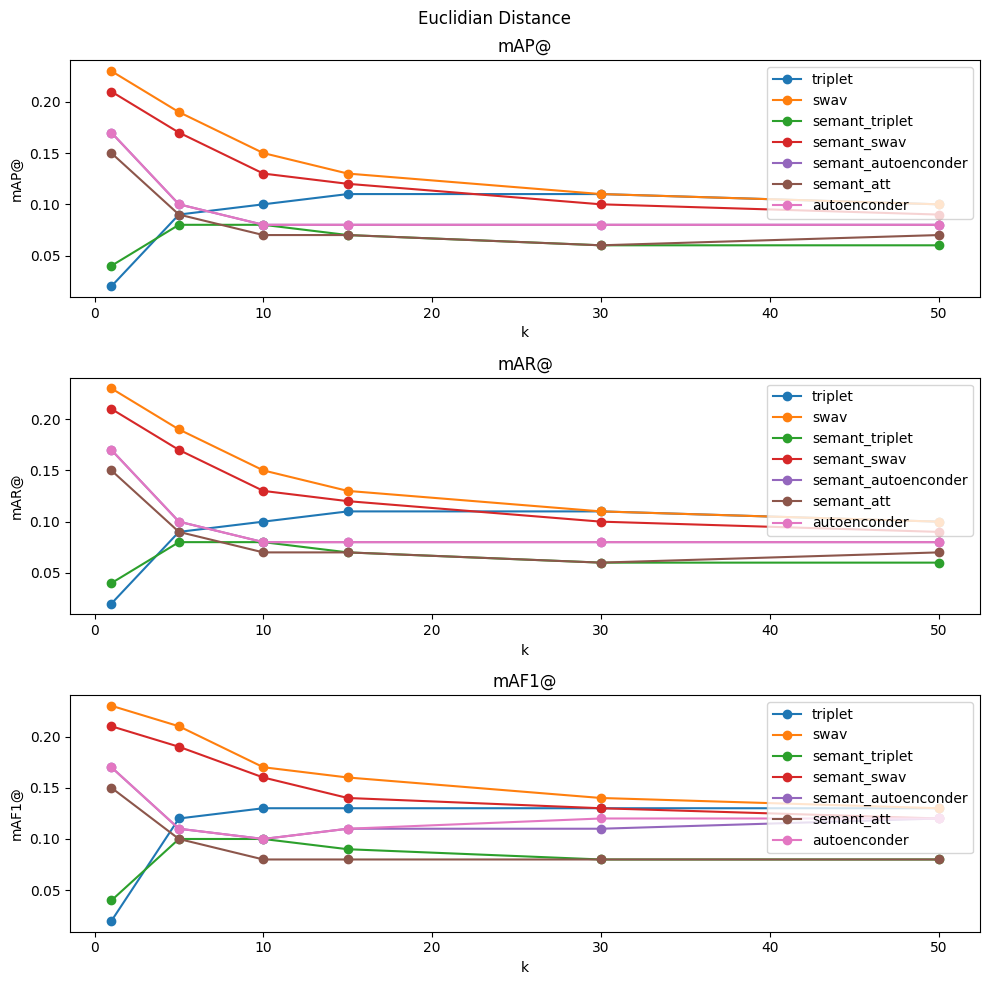

In [105]:
import matplotlib.pyplot as plt


# Plot
fig, axs = plt.subplots(3, figsize=(10, 10))

metrics = ['mAP@', 'mAR@', 'mAF1@']
colors = ['blue', 'green', 'orange']
df_ = df[df['distance'] == 'euclidian']
for i, metric in enumerate(metrics):
    for model in df_['model'].unique():
        df_filtered = df_[df_['model'] == model]
        axs[i].plot(df_filtered['k'], df_filtered[metric], marker='o', label=model)

    axs[i].set_title(metric)
    axs[i].set_xlabel('k')
    axs[i].set_ylabel(metric)
    axs[i].legend()

plt.suptitle("Euclidian Distance")
plt.tight_layout()
plt.show()

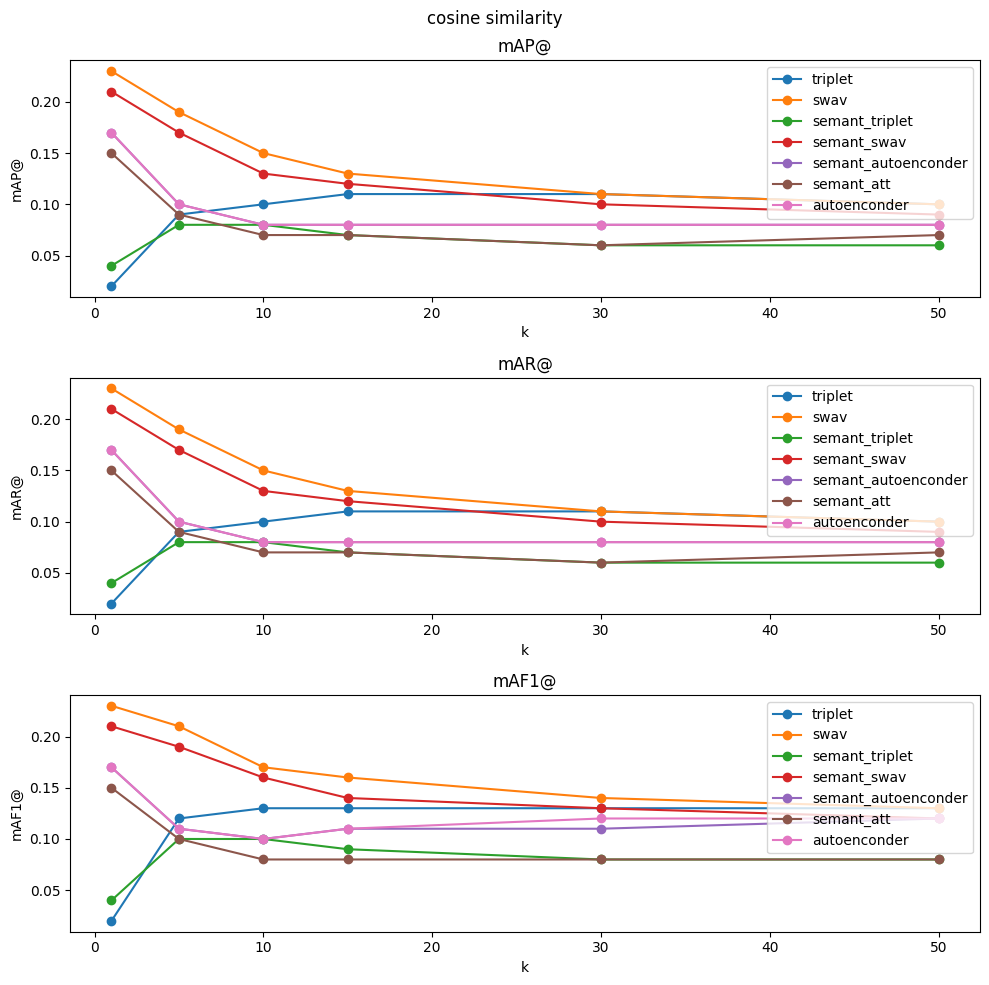

In [106]:
import matplotlib.pyplot as plt


# Plot
fig, axs = plt.subplots(3, figsize=(10, 10))

metrics = ['mAP@', 'mAR@', 'mAF1@']
colors = ['blue', 'green', 'orange']
df_ = df[df['distance'] == 'euclidian']
for i, metric in enumerate(metrics):
    for model in df_['model'].unique():
        df_filtered = df_[df_['model'] == model]
        axs[i].plot(df_filtered['k'], df_filtered[metric], marker='o', label=model)

    axs[i].set_title(metric)
    axs[i].set_xlabel('k')
    axs[i].set_ylabel(metric)
    axs[i].legend()

plt.suptitle("cosine similarity")
plt.tight_layout()
plt.show()

In [14]:
df[df.model=='semant_att']

,model,distance,mAP@,k
36,semant_att,euclidian,0.06,1
37,semant_att,euclidian,0.06,5
38,semant_att,euclidian,0.05,10
39,semant_att,euclidian,0.04,15
40,semant_att,euclidian,0.04,30
41,semant_att,euclidian,0.04,50
42,semant_att,dot product,0.15,1
43,semant_att,dot product,0.11,5
44,semant_att,dot product,0.11,10
45,semant_att,dot product,0.11,15


In [107]:
df.to_csv('query_same_dataset.csv')